In [14]:
#importing all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import nltk
import string
import math
import re
%matplotlib inline
warnings.filterwarnings("ignore")
import re
import random
import pandas as pd
import urllib.request
import textwrap
from nltk.corpus import stopwords
from collections import Counter
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score, silhouette_score
from gensim.models import Word2Vec
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [15]:
# Creating the Function with 2 parameters
def partition(bi, la):
    url = f"http://www.gutenberg.org/files/{bi}/{bi}-0.txt" # Downloading the book from gutenberg website
    response = urllib.request.urlopen(url)
    raw_text = response.read().decode('utf-8')
    # cleaned_text = re.sub(r'\b\w*\d+\w*\b|\w*_\w*|(?<=\w)\'(?=\w)', '', raw_text).strip()
    cleaned_text = re.sub(r'\r\n?', '\n', raw_text).strip() # Cleaning the text
    wo = re.findall(r'\w+', cleaned_text) # Splitting to list of words
    random.seed(69)
    starting_indices = random.sample(range(0, len(wo) - 100), 200) # Selecting 200 random starting indices for partitions
    partitions = [] #creating empty list for partitions
    for i in starting_indices: #iterating through the starting indices
        partition = wo[i:i+150]
        partitions.append(partition) #appending each partition to the partitions list
    df = pd.DataFrame({'label': la, 'partition': partitions}) # Creating a DF to store all the partitions
    return df #the dataframe is returned

bi_list = [1342, 2446, 308, 69916, 69790] # List of book ids on the website
la_list = ['a', 'b', 'c', 'd', 'e']
df_list = [] #empty lsit

for bi, la in zip(bi_list, la_list):
    df_list.append(partition(bi, la)) #function is being called inside and the values are appended

df = pd.concat(df_list)# Concatenating the DataFrames and exporting to CSV format
df['partition'] = df['partition'].apply(lambda x: ' '.join(map(str, x)))
df.to_csv('finaloutput.csv', index=False)

In [16]:
df["partition"]=df["partition"].apply(lambda x: " ".join([w for w in x.split() if len(w)>2]))

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
print(df.head())

   label                                          partition
0      0  the king during his mayoralty The distinction ...
1      0  the servants were withdrawn thought time have ...
2      0  avoid the notice his cousins from conviction t...
3      0  girls they are nothing _her_ You have sweet ro...
4      0  improve you and believe you thought her rather...


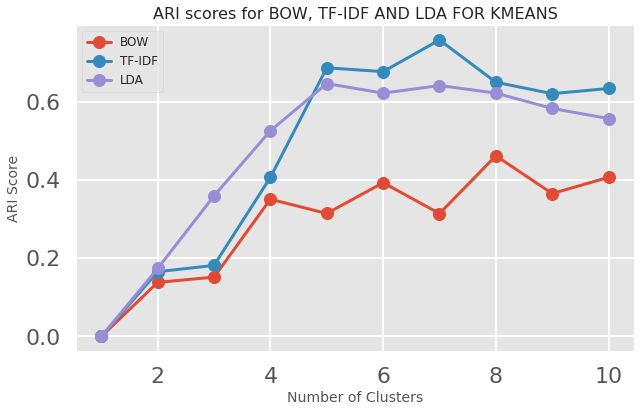

In [18]:
# Extracting the book labels and text partitions
book_labels = df["label"].values
text_partitions = df["partition"].values

# Preprocessing the text data
vectorizer_bow = CountVectorizer(max_features=1000, stop_words="english")
vectorizer_tfidf = TfidfVectorizer(max_features=1000, stop_words="english")

X_bow = vectorizer_bow.fit_transform(text_partitions)
X_tfidf = vectorizer_tfidf.fit_transform(text_partitions)

# Training the LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
X_lda = lda.fit_transform(X_tfidf)

# Creating 10 clusters
n_clusters_range = range(1, 11)
ari_scores_bow = []
ari_scores_tfidf = []
ari_scores_lda = []

for n_clusters in n_clusters_range:
    
    # Using k-means clustering
    kmeans_bow = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_bow.fit(X_bow)
    y_pred_bow = kmeans_bow.labels_

    kmeans_tfidf = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_tfidf.fit(X_tfidf)
    y_pred_tfidf = kmeans_tfidf.labels_

    kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_lda.fit(X_lda)
    y_pred_lda = kmeans_lda.labels_

    #Calculating ARI score for k-means 
    ari_bow = adjusted_rand_score(book_labels, y_pred_bow)
    ari_tfidf = adjusted_rand_score(book_labels, y_pred_tfidf)
    ari_lda = adjusted_rand_score(book_labels, y_pred_lda)

    ari_scores_bow.append(ari_bow)
    ari_scores_tfidf.append(ari_tfidf)
    ari_scores_lda.append(ari_lda)

# Plotting the ARI scores for different number of clusters
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(n_clusters_range, ari_scores_bow, '-o', label='BOW')
ax.plot(n_clusters_range, ari_scores_tfidf, '-o', label='TF-IDF')
ax.plot(n_clusters_range, ari_scores_lda, '-o', label='LDA')

ax.set_xlabel('Number of Clusters', fontsize=14)
ax.set_ylabel('ARI Score', fontsize=14)
ax.set_title('ARI scores for BOW, TF-IDF AND LDA FOR KMEANS', fontsize=16)
ax.legend(fontsize=12)
 
plt.show()

# Ncluster=5 is our breaking point (ELBOW METHOD)

In [19]:
# Clustering the data using K-means
n_clusters = 5
kmeans_bow = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_bow.fit(X_bow)
y_pred_bow_kmeans = kmeans_bow.labels_

kmeans_tfidf = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_tfidf.fit(X_tfidf)
y_pred_tfidf_kmeans = kmeans_tfidf.labels_

kmeans_lda = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_lda.fit(X_lda)
y_pred_lda_kmeans = kmeans_lda.labels_

# Clustering the data using EM algorithm
em_bow = GaussianMixture(n_components=n_clusters, random_state=42)
em_bow.fit(X_bow.toarray())
y_pred_bow_em = em_bow.predict(X_bow.toarray())

em_tfidf = GaussianMixture(n_components=n_clusters, random_state=42)
em_tfidf.fit(X_tfidf.toarray())
y_pred_tfidf_em = em_tfidf.predict(X_tfidf.toarray())

em_lda = GaussianMixture(n_components=n_clusters, random_state=42)
em_lda.fit(X_lda)
y_pred_lda_em = em_lda.predict(X_lda)

# Clustering the data using hierarchical clustering algorithm
hierarchical_bow = AgglomerativeClustering(n_clusters=n_clusters)
y_pred_bow_hierarchical = hierarchical_bow.fit_predict(X_bow.toarray())

hierarchical_tfidf = AgglomerativeClustering(n_clusters=n_clusters)
y_pred_tfidf_hierarchical = hierarchical_tfidf.fit_predict(X_tfidf.toarray())

hierarchical_lda = AgglomerativeClustering(n_clusters=n_clusters)
y_pred_lda_hierarchical = hierarchical_lda.fit_predict(X_lda)

# Evaluating the clustering performance (ARI) of the above clustering algorithms
ari_bow_kmeans = adjusted_rand_score(book_labels, y_pred_bow_kmeans)
ari_tfidf_kmeans = adjusted_rand_score(book_labels, y_pred_tfidf_kmeans)
ari_lda_kmeans = adjusted_rand_score(book_labels, y_pred_lda_kmeans)

ari_bow_em = adjusted_rand_score(book_labels, y_pred_bow_em)
ari_tfidf_em = adjusted_rand_score(book_labels, y_pred_tfidf_em)
ari_lda_em = adjusted_rand_score(book_labels, y_pred_lda_em)

ari_bow_hierarchical = adjusted_rand_score(book_labels, y_pred_bow_hierarchical)
ari_tfidf_hierarchical = adjusted_rand_score(book_labels, y_pred_tfidf_hierarchical)
ari_lda_hierarchical = adjusted_rand_score(book_labels, y_pred_lda_hierarchical)

# Printing the evaluation results
print("ARI for BOW clustering with K-means: {:.3f}".format(ari_bow_kmeans))
print("ARI for TF-IDF clustering with K-means: {:.3f}".format(ari_tfidf_kmeans))
print("ARI for LDA clustering with K-means: {:.3f}".format(ari_lda_kmeans))

print("ARI for BOW clustering with EM: {:.3f}".format(ari_bow_em))
print("ARI for TF-IDF clustering with EM: {:.3f}".format(ari_tfidf_em))
print("ARI for LDA clustering with EM: {:.3f}".format(ari_lda_em))

print("ARI for BOW clustering with hierarchical clustering: {:.3f}".format(ari_bow_hierarchical))
print("ARI for TF-IDF clustering with hierarchical clustering: {:.3f}".format(ari_tfidf_hierarchical))
print("ARI for LDA clustering with hierarchical clustering: {:.3f}".format(ari_lda_hierarchical))

ARI for BOW clustering with K-means: 0.315
ARI for TF-IDF clustering with K-means: 0.688
ARI for LDA clustering with K-means: 0.648
ARI for BOW clustering with EM: 0.309
ARI for TF-IDF clustering with EM: 0.565
ARI for LDA clustering with EM: 0.237
ARI for BOW clustering with hierarchical clustering: 0.350
ARI for TF-IDF clustering with hierarchical clustering: 0.628
ARI for LDA clustering with hierarchical clustering: 0.648


In [20]:
# Tokenizing the partitions and creating a dictionary
partition_tokens = [partition.split() for partition in df['partition']]
dictionary = corpora.Dictionary(partition_tokens)

# Creating a bag-of-words corpus from the dictionary and partitions
corpus = [dictionary.doc2bow(partition) for partition in partition_tokens]

# Training an LDA model with 5 topics and 65 passes over the corpus
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=65)

# Calculating coherence score using C_v metric
coherence_model_lda = CoherenceModel(model=lda_model, texts=partition_tokens, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score:', coherence_lda)

Coherence Score: 0.48138466122641416


In [21]:
# Calculate the Cohen's kappa score
kappa_bow_kmeans = cohen_kappa_score(book_labels, y_pred_bow_kmeans)
kappa_tfidf_kmeans = cohen_kappa_score(book_labels, y_pred_tfidf_kmeans)
kappa_lda_kmeans = cohen_kappa_score(book_labels, y_pred_lda_kmeans)

kappa_bow_em = cohen_kappa_score(book_labels, y_pred_bow_em)
kappa_tfidf_em = cohen_kappa_score(book_labels, y_pred_tfidf_em)
kappa_lda_em = cohen_kappa_score(book_labels, y_pred_lda_em)

kappa_bow_hierarchical = cohen_kappa_score(book_labels, y_pred_bow_hierarchical)
kappa_tfidf_hierarchical = cohen_kappa_score(book_labels, y_pred_tfidf_hierarchical)
kappa_lda_hierarchical = cohen_kappa_score(book_labels, y_pred_lda_hierarchical)

# Calculate the silhouette score
silhouette_bow_kmeans = silhouette_score(X_bow, y_pred_bow_kmeans)
silhouette_tfidf_kmeans = silhouette_score(X_tfidf, y_pred_tfidf_kmeans)
silhouette_lda_kmeans = silhouette_score(X_lda, y_pred_lda_kmeans)

silhouette_bow_em = silhouette_score(X_bow, y_pred_bow_em)
silhouette_tfidf_em = silhouette_score(X_tfidf, y_pred_tfidf_em)
silhouette_lda_em = silhouette_score(X_lda, y_pred_lda_em)

silhouette_bow_hierarchical = silhouette_score(X_bow, y_pred_bow_hierarchical)
silhouette_tfidf_hierarchical = silhouette_score(X_tfidf, y_pred_tfidf_hierarchical)
silhouette_lda_hierarchical = silhouette_score(X_lda, y_pred_lda_hierarchical)

# Print the evaluation results
print("ARI for BOW clustering with K-means: {:.3f}".format(ari_bow_kmeans))
print("ARI for TF-IDF clustering with K-means: {:.3f}".format(ari_tfidf_kmeans))
print("ARI for LDA clustering with K-means: {:.3f}".format(ari_lda_kmeans))
print("Coherence Score for LDA model: {:.3f}".format(coherence_lda))
print("Kappa for BOW clustering with K-means: {:.3f}".format(kappa_bow_kmeans))
print("Kappa for TF-IDF clustering with K-means: {:.3f}".format(kappa_tfidf_kmeans))
print("Kappa for LDA clustering with K-means: {:.3f}".format(kappa_lda_kmeans))
print("Silhouette score for BOW clustering with K-means: {:.3f}".format(silhouette_bow_kmeans))
print("Silhouette score for TF-IDF clustering with K-means: {:.3f}".format(silhouette_tfidf_kmeans))
print("Silhouette score for LDA clustering with K-means: {:.3f}".format(silhouette_lda_kmeans))

print("ARI for BOW clustering with EM: {:.3f}".format(ari_bow_em))
print("ARI for TF-IDF clustering with EM: {:.3f}".format(ari_tfidf_em))
print("ARI for LDA clustering with EM: {:.3f}".format(ari_lda_em))
print("Kappa for BOW clustering with EM: {:.3f}".format(kappa_bow_em))
print("Kappa for TF-IDF clustering with EM: {:.3f}".format(kappa_tfidf_em))
print("Kappa for LDA clustering with EM: {:.3f}".format(kappa_lda_em))
print("Silhouette Score for BOW clustering with EM: {:.3f}".format(silhouette_bow_em))
print("Silhouette Score for TF-IDF clustering with EM: {:.3f}".format(silhouette_tfidf_em))
print("Silhouette Score for LDA clustering with EM: {:.3f}".format(silhouette_lda_em))

print("ARI for BOW clustering with hierarchical clustering: {:.3f}".format(ari_bow_hierarchical))
print("ARI for TF-IDF clustering with hierarchical clustering: {:.3f}".format(ari_tfidf_hierarchical))
print("ARI for LDA clustering with hierarchical clustering: {:.3f}".format(ari_lda_hierarchical))
print("Kappa for BOW clustering with hierarchical clustering: {:.3f}".format(kappa_bow_hierarchical))
print("Kappa for TF-IDF clustering with hierarchical clustering: {:.3f}".format(kappa_tfidf_hierarchical))
print("Kappa for LDA clustering with hierarchical clustering: {:.3f}".format(kappa_lda_hierarchical))
print("Silhouette Score for BOW clustering with hierarchical clustering: {:.3f}".format(silhouette_bow_hierarchical))
print("Silhouette Score for TF-IDF clustering with hierarchical clustering: {:.3f}".format(silhouette_tfidf_hierarchical))
print("Silhouette Score for LDA clustering with hierarchical clustering: {:.3f}".format(silhouette_lda_hierarchical))


ARI for BOW clustering with K-means: 0.315
ARI for TF-IDF clustering with K-means: 0.688
ARI for LDA clustering with K-means: 0.648
Coherence Score for LDA model: 0.481
Kappa for BOW clustering with K-means: 0.376
Kappa for TF-IDF clustering with K-means: 0.225
Kappa for LDA clustering with K-means: -0.004
Silhouette score for BOW clustering with K-means: 0.056
Silhouette score for TF-IDF clustering with K-means: 0.051
Silhouette score for LDA clustering with K-means: 0.512
ARI for BOW clustering with EM: 0.309
ARI for TF-IDF clustering with EM: 0.565
ARI for LDA clustering with EM: 0.237
Kappa for BOW clustering with EM: 0.266
Kappa for TF-IDF clustering with EM: 0.005
Kappa for LDA clustering with EM: 0.106
Silhouette Score for BOW clustering with EM: 0.020
Silhouette Score for TF-IDF clustering with EM: 0.049
Silhouette Score for LDA clustering with EM: 0.059
ARI for BOW clustering with hierarchical clustering: 0.350
ARI for TF-IDF clustering with hierarchical clustering: 0.628
ARI 

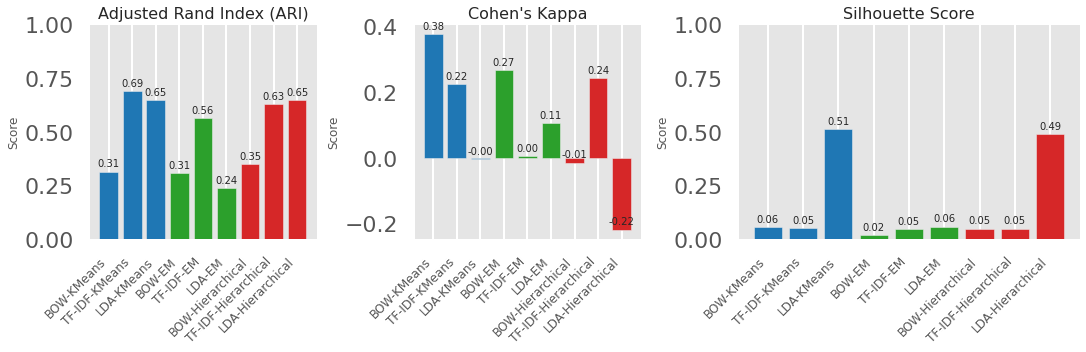

In [22]:
import matplotlib.pyplot as plt

# Create lists for evaluation metrics
ari_scores = [ari_bow_kmeans, ari_tfidf_kmeans, ari_lda_kmeans, ari_bow_em, ari_tfidf_em, ari_lda_em, ari_bow_hierarchical, ari_tfidf_hierarchical, ari_lda_hierarchical]
kappa_scores = [kappa_bow_kmeans, kappa_tfidf_kmeans, kappa_lda_kmeans, kappa_bow_em, kappa_tfidf_em, kappa_lda_em, kappa_bow_hierarchical, kappa_tfidf_hierarchical, kappa_lda_hierarchical]
silhouette_scores = [silhouette_bow_kmeans, silhouette_tfidf_kmeans, silhouette_lda_kmeans, silhouette_bow_em, silhouette_tfidf_em, silhouette_lda_em, silhouette_bow_hierarchical, silhouette_tfidf_hierarchical, silhouette_lda_hierarchical]

# Create labels for clustering algorithms
labels = ['BOW-KMeans', 'TF-IDF-KMeans', 'LDA-KMeans', 'BOW-EM', 'TF-IDF-EM', 'LDA-EM', 'BOW-Hierarchical', 'TF-IDF-Hierarchical', 'LDA-Hierarchical']

# Set figure size
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [2, 2, 3]})

# Plot ARI scores
axs[0].bar(labels, ari_scores, color=['#1f77b4', '#1f77b4', '#1f77b4', '#2ca02c', '#2ca02c', '#2ca02c', '#d62728', '#d62728', '#d62728'])
axs[0].set_title('Adjusted Rand Index (ARI)', fontsize=16)
axs[0].set_ylabel('Score', fontsize=12)
axs[0].set_xticklabels(labels, fontsize=12, rotation=45, ha='right')
axs[0].set_ylim([0, 1])
axs[0].grid(axis='y')

# Plot Cohen's Kappa scores
axs[1].bar(labels, kappa_scores, color=['#1f77b4', '#1f77b4', '#1f77b4', '#2ca02c', '#2ca02c', '#2ca02c', '#d62728', '#d62728', '#d62728'])
axs[1].set_title('Cohen\'s Kappa', fontsize=16)
axs[1].set_ylabel('Score', fontsize=12)
axs[1].set_xticklabels(labels, fontsize=12, rotation=45, ha='right')
# axs[1].set_ylim([0, 1])
axs[1].grid(axis='y')

# Plot Silhouette scores
axs[2].bar(labels, silhouette_scores, color=['#1f77b4', '#1f77b4', '#1f77b4', '#2ca02c', '#2ca02c', '#2ca02c', '#d62728', '#d62728', '#d62728'])
axs[2].set_title('Silhouette Score', fontsize=16)
axs[2].set_ylabel('Score', fontsize=12)
axs[2].set_xticklabels(labels, fontsize=12, rotation=45, ha='right')
axs[2].set_ylim([0, 1])
axs[2].grid(axis='y')

for i in range(len(axs)):
    for rect in axs[i].patches:
        height = rect.get_height()
        axs[i].annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

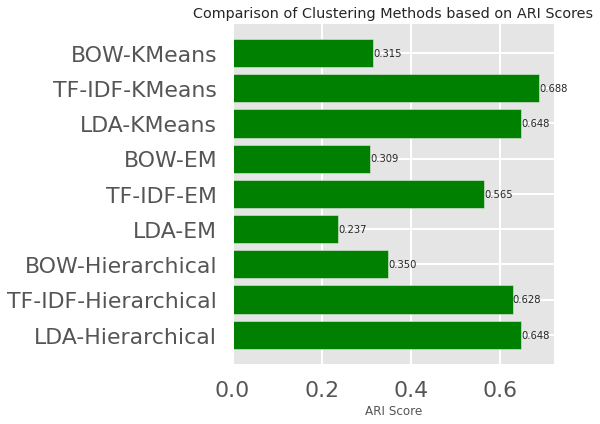

In [23]:
import matplotlib.pyplot as plt
import numpy as npÍ

# Defining the labels and ARI scores for each clustering algorithm
labels = ["BOW-KMeans", "TF-IDF-KMeans", "LDA-KMeans", 
          "BOW-EM", "TF-IDF-EM", "LDA-EM",
          "BOW-Hierarchical", "TF-IDF-Hierarchical", "LDA-Hierarchical"]
ari_scores = [ari_bow_kmeans, ari_tfidf_kmeans, ari_lda_kmeans, 
              ari_bow_em, ari_tfidf_em, ari_lda_em, 
              ari_bow_hierarchical, ari_tfidf_hierarchical, ari_lda_hierarchical]

# Setting up the plot
fig, ax = plt.subplots(figsize=(8,6))
y_pos = np.arange(len(labels))
colors = ['red' if score < 0 else 'green' for score in ari_scores]  # red for negative scores, green for positive scores

# Creating the horizontal bar chart
ax.barh(y_pos, ari_scores, align='center', color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('ARI Score')
ax.set_title('Comparison of Clustering Methods based on ARI Scores')

# Adding value labels to each bar
for i, score in enumerate(ari_scores):
    ax.text(score, i, f"{score:.3f}", ha='left', va='center')

plt.tight_layout()
plt.show()


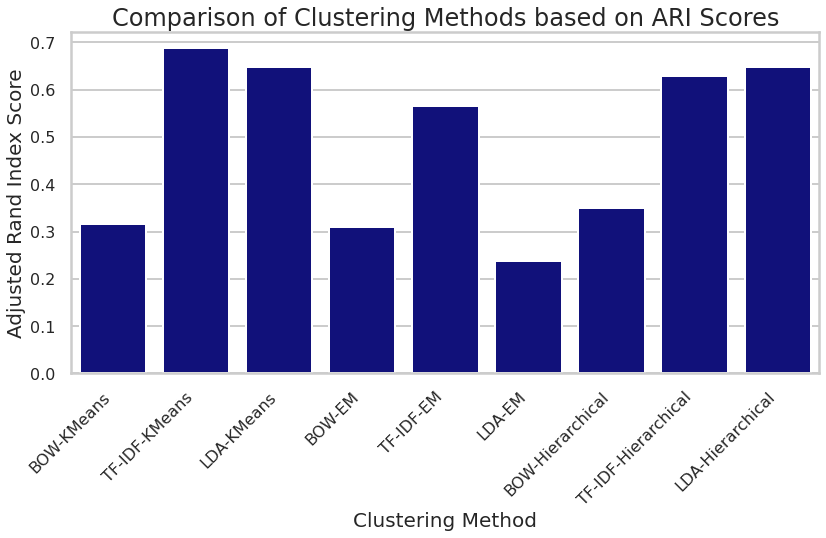

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style and context of the plot
sns.set_style("whitegrid")
sns.set_context("poster")

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=labels, y=ari_scores, color='darkblue')
ax.set_xlabel('Clustering Method', fontsize=20)
ax.set_ylabel('Adjusted Rand Index Score', fontsize=20)
ax.set_title('Comparison of Clustering Methods based on ARI Scores', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [25]:
# Download stopwords
nltk.download('stopwords')

# Define the stop words
stop_words = set(stopwords.words('english'))
df["partition"] = df["partition"].str.lower()

# Remove stop words from the corpus
df["partition"] = df["partition"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Get the top 10 frequent words in the corpus
word_counter = Counter(df["partition"].str.split(expand=True).stack())
top_words = [word for word, count in word_counter.most_common(10)]

# Print the top 10 frequent words
print("Top 10 frequent words:")
print(top_words)

Top 10 frequent words:
['stockmann', 'said', 'would', 'one', 'could', 'man', 'know', 'mrs', 'kim', 'two']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
